# Pseudo Perplexity

## Dependencies

In [1]:
# ! pip install amplify seaborn

In [2]:

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils import load_csv_dataset, load_from_hf, load_from_mila

[2024-06-05 17:30:22,874] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
# Model
source = "mila"
model_name = "AMPLIFY350M"
model_path = "../outputs/MILA_PLM_350M_UR100P/checkpoint/pytorch_model.pt"
tokenizer_path = None 
config_path = "../outputs/MILA_PLM_350M_UR100P/checkpoint/config.yaml"
batch_size = 512
device = "cuda"
compile = False
fp16 = True

# Dataset
data_name = "UniProt"
data_path = "../uniref/mila/uniprot_dev.csv"
n_proteins = 100

# Log
output_file = "../outputs/AMPLIFY_UniProt_PPL.csv"

In [4]:
# Get model and tokenizer
if source == "hf":
    model, tokenizer = load_from_hf(model_path, tokenizer_path, fp16=fp16)
elif source == "mila":
    model, tokenizer = load_from_mila(model_path, config_path)
else:
    raise Exception("Only 'hf' and 'mila' sources are supported, not {source}.")
model.to(device)
torch.compile(model, disable=~compile)

OptimizedModule(
  (_orig_mod): AMPLIFY(
    (encoder): Embedding(27, 960, padding_idx=0)
    (transformer_encoder): ModuleList(
      (0-31): 32 x EncoderBlock(
        (q): Linear(in_features=960, out_features=960, bias=False)
        (k): Linear(in_features=960, out_features=960, bias=False)
        (v): Linear(in_features=960, out_features=960, bias=False)
        (wo): Linear(in_features=960, out_features=960, bias=False)
        (resid_dropout): Dropout(p=0, inplace=False)
        (ffn): SwiGLU(
          (w12): Linear(in_features=960, out_features=5120, bias=False)
          (w3): Linear(in_features=2560, out_features=960, bias=False)
        )
        (attention_norm): RMSNorm()
        (ffn_norm): RMSNorm()
        (ffn_dropout): Dropout(p=0, inplace=False)
      )
    )
    (layer_norm_2): RMSNorm()
    (decoder): Linear(in_features=960, out_features=27, bias=True)
  )
)

In [5]:
# Prepare the dataset
dataset = load_csv_dataset(data_path, n_proteins)

# Generator that, for each protein, tokenize, mask each residue, and batch
def batch_tokenize_mask(dataset, tokenizer, batch_size):
    for label, protein in dataset:
        x = torch.as_tensor(tokenizer.encode(protein, max_length=512, truncation=True))
        x = x.repeat(x.size(0), 1)
        y = torch.where(torch.eye(x.size(0), dtype=torch.bool), x, -100)
        x = torch.where(torch.eye(x.size(0), dtype=torch.bool), tokenizer.mask_token_id, x)
        for _x, _y in zip(torch.split(x, batch_size, 0), torch.split(y, batch_size, 0)):
            yield (label, _x, _y)

# Dataloader
dataloader = batch_tokenize_mask(dataset, tokenizer, batch_size)

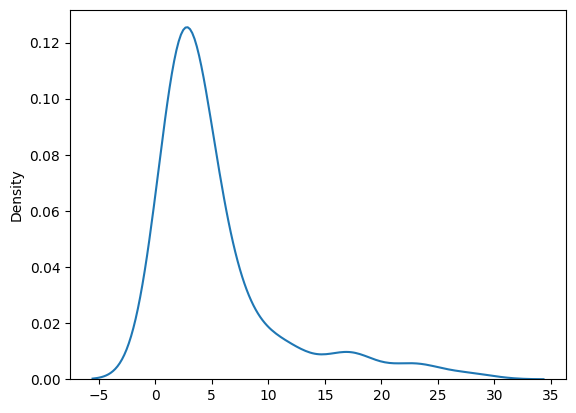

In [6]:
# Compute pseudo-perplexity
with torch.no_grad(), torch.autocast(device_type=device, dtype=torch.float16, enabled=fp16):
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    losses = dict()
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100, reduction="none")
    for label, x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x).logits
        loss = loss_fn(logits.transpose(1, 2), y).sum(-1).tolist()
        losses[label] = losses[label] + loss if label in losses else loss

# Save the pseudo-perplexities into a csv
with open(output_file, "w") as file:
    file.write("name,pseudo-perplexity\n")
    for k, v in losses.items():
        file.write(f"{k},{np.exp(np.mean(v))}\n")

# Plot the distribution of pseudo-perplexities
sns.kdeplot([np.exp(np.mean(v)) for v in losses.values()])
plt.show()